In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gputil ffpb
import GPUtil as GPU
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
gpu = GPU.getGPUs()[0]
!nvidia-smi -L

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
GPU 0: Tesla T4 (UUID: GPU-ce3aed8e-aea1-7327-ea45-67e31d5b9d88)


In [ ]:
## installation
!pip install ftfy==5.8 transformers
!pip install git+https://github.com/openai/CLIP.git --no-deps
!pip install sentence_transformers
!pip install kornia
!pip install git+https://github.com/eps696/aphantasia
!pip install omegaconf>=2.0.0 torchmetrics==0.6.2 pytorch-lightning>=1.0.8 einops>=0.3.0
!git clone https://github.com/CompVis/taming-transformers
!mv taming-transformers/* ./
!pip install streamlit
!pip install moviepy
!pip install ffmpeg
!pip install gtts
!pip install langdetect
!pip install Pillow
!pip install arabic-reshaper
!pip install python-bidi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-obxnqozy
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-obxnqozy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/eps696/aphantasia to /tmp/pip-req-build-oid3i9ra
  Running command git clone -q https://github.com/eps696/aphantasia /tmp/pip-req-build-oid3i9ra
fatal: destination path 'taming-transformers' already exists and is not an empty directory.
mv: cannot stat 'taming-transformers/*': No such file or directory
Lo

In [ ]:
import re
import os
import cv2
import matplotlib.pyplot as plt
import glob
import PIL
from PIL import Image, ImageDraw, ImageFont
from moviepy.editor import *
from gtts import gTTS
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import kornia
from aphantasia.utils import slice_imgs, txt_clean, old_torch
from aphantasia import transforms
import pytorch_lightning as pl
import yaml
from omegaconf import OmegaConf
import clip
from sentence_transformers import SentenceTransformer
from taming.modules.diffusionmodules.model import Decoder
from taming.modules.vqvae.quantize import VectorQuantizer2 as VectorQuantizer
from taming.modules.vqvae.quantize import GumbelQuantize
from langdetect import detect
import arabic_reshaper
from bidi.algorithm import get_display

In [ ]:

class VQModel(pl.LightningModule):
  def __init__(self, ddconfig, n_embed, embed_dim, remap=None, sane_index_shape=False, **kwargs_ignore):  # tell vector quantizer to return indices as bhw
    super().__init__()
    self.decoder = Decoder(**ddconfig)
    self.quantize = VectorQuantizer(n_embed, embed_dim, beta=0.25, remap=remap, sane_index_shape=sane_index_shape)
  def decode(self, quant):
    return self.decoder(quant)

class GumbelVQ(VQModel):
  def __init__(self, ddconfig, n_embed, embed_dim, kl_weight=1e-8, remap=None, **kwargs_ignore):
    z_channels = ddconfig["z_channels"]
    super().__init__(ddconfig, n_embed, embed_dim)
    self.quantize = GumbelQuantize(z_channels, embed_dim, n_embed=n_embed, kl_weight=kl_weight, temp_init=1.0, remap=remap)

class latents(torch.nn.Module):
  def __init__(self, shape):
    super(latents, self).__init__()
    init_rnd = torch.zeros(shape).normal_(0.,4.)
    self.lats = torch.nn.Parameter(init_rnd.cuda())
  def forward(self):
    return self.lats

def load_config(VQGAN_model, config_path):
  config = OmegaConf.load(config_path)
  return config

def load_vqgan(VQGAN_model, config, ckpt_path=None):
  if VQGAN_model == "gumbel_f8-8192":
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def vqgan_image(model, z):
  x = model.decode(z)
  x = (x+1.)/2.
  return x

def enc_text(txt, model_clip, model_lang, multilang):
  if multilang:
    emb = model_lang.encode([txt], convert_to_tensor=True, show_progress_bar=False)
  else:
    emb = model_clip.encode_text(clip.tokenize(txt).cuda())
  return emb.detach().clone()

img_array = []

def save_img(img, txt, fname=None):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))  
  img = np.clip(img*255, 0, 255).astype(np.uint8)
  img_array.append(img)
  if fname is not None:
    imageio.imsave(fname, np.array(img))
    imageio.imsave(txt + '.jpg', np.array(img))

def checkout(num, txt, model_vqgan, lats, tempdir):
  with torch.no_grad():
    img = vqgan_image(model_vqgan, lats()).cpu().numpy()[0]
  save_img(img, txt, os.path.join(f"/content/{tempdir}", '%04d.jpg' % num))

def train(i, txt, model_vqgan, lats, tempdir, save_freq, samples, modsize, trform_f, model_clip, txt_enc, sign, optimizer, align, style, txt_enc2):
  loss = 0
  img_out = vqgan_image(model_vqgan, lats())
  img_sliced = slice_imgs([img_out], samples, modsize, trform_f, align, macro=0.4)[0]
  out_enc = model_clip.encode_image(img_sliced)
  if len(text) > 0:
    loss += sign * torch.cosine_similarity(txt_enc, out_enc, dim=-1).mean()
  if len(style) > 0:
    loss += sign * 0.5 * torch.cosine_similarity(txt_enc2, out_enc, dim=-1).mean()
  del img_out, img_sliced, out_enc; torch.cuda.empty_cache()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if i % save_freq == 0:
    checkout(i // save_freq, txt, model_vqgan, lats, tempdir)
  return lats

def create_images(text, sideY, sideX, scale_res, model_clip, model_lang, multilang, learning_rate, steps, model_vqgan, save_freq, samples, modsize, trform_f, sign, txt_enc2, align):
  images = []
  workdir = 'images_samples'
  os.makedirs(os.path.join("./" , "final_images"), exist_ok=True)
  for i in range(len(text)):
    tempdir = os.path.join(workdir, '%s%s' % (txt_clean(text[i])[:100], txt_clean(style)[:50]))
    os.makedirs(tempdir, exist_ok=True)
    lats = latents([1, 256, sideY//scale_res, sideX//scale_res]).cuda()
    txt_enc = enc_text(text[i], model_clip, model_lang, multilang)
    optimizer = torch.optim.AdamW(lats.parameters(), learning_rate, weight_decay=0.01, amsgrad=True)
    temp = lats
    for j in range(steps):
      new_lats = train(j, text[i], model_vqgan, lats, tempdir, save_freq, samples, modsize, trform_f, model_clip, txt_enc, sign, optimizer, align, style, txt_enc2)
      temp = new_lats
    list_of_files = glob.glob(f"/content/{tempdir}/*.jpg")
    latest_file = max(list_of_files, key=os.path.getctime)
    image = open(latest_file, 'rb')
    image = PIL.Image.open(image)
    image.save("/content/final_images/" + f'{text[i]}.jpg')
    images.append(latest_file)
  return images

def write_on_images(images, text, lang):
  os.makedirs(os.path.join("./" , "images_with_texts"), exist_ok=True)
  for i in range(len(images)):
    image = open(images[i], 'rb')
    img = PIL.Image.open(image)
    width, height = img.size
    draw = ImageDraw.Draw(img)
    if lang == 'ar':
      sentence = arabic_reshaper.reshape(text[i])
      sentence = get_display(sentence)
    else:
      sentence = text[i]
    font = ImageFont.truetype("/content/drive/MyDrive/GP/fonts/Amiri-Bold.ttf", 35)
    w, h = font.getsize(sentence)
    Coords = ((width-w)/2, height-h-5)
    color = (255, 255, 0)
    draw.text(Coords, sentence, color, font=font)
    img.save("/content/images_with_texts/" + f'pic_text{i}.jpg')

def create_audios(text, lang):
  os.makedirs("audio_files", exist_ok=True)
  for i in range(len(text)):
    myobj = gTTS(text=text[i], lang=lang, slow=False)
    myobj.save(f"/content/audio_files/audio{i}.mp3")
  audio_paths = glob.glob(f"/content/audio_files/*.mp3")
  audio_paths = sorted(audio_paths)
  return audio_paths

def create_videos(audio_paths):
  os.makedirs("video_files", exist_ok=True)
  videos_path = "/content/video_files"
  images_texts = glob.glob(f"/content/images_with_texts/*.jpg")
  images_texts = sorted(images_texts)
  for i in range(len(images_texts)):
    add_static_image_to_audio(images_texts[i], audio_paths[i], f"{videos_path}/video{i}.mp4")
  video_clip_paths = glob.glob(f"/content/video_files/*.mp4")
  video_clip_paths = sorted(video_clip_paths)
  return video_clip_paths

def add_static_image_to_audio(image_path, audio_path, output_path):
    audio_clip = AudioFileClip(audio_path)
    image_clip = ImageClip(image_path)
    video_clip = image_clip.set_audio(audio_clip)
    video_clip.duration = audio_clip.duration
    video_clip.fps = 1
    video_clip.write_videofile(output_path, fps=60)

def concatenate_videos(video_clip_paths):
  os.makedirs("final_video", exist_ok=True)
  video_path = "/content/final_video/finalVideo.mp4"
  clips = [VideoFileClip(c) for c in video_clip_paths]
  final_clip = concatenate_videoclips(clips)
  final_clip.write_videofile(video_path, codec="libx264", fps=60)
  return video_path

def run_model(text, style):
  # paraameters
  lang = detect(text)
  sideX = 300
  sideY = 300
  steps = 100
  samples = 40
  learning_rate = 0.1
  save_freq = 1
  scale_res = 8
  sign = -1.
  align = "uniform" # 'uniform', 'central', 'overscan'
  aug_transform = "custom"  # 'custom', 'elastic', 'fast'
  
  multilang = False
  if lang != "en":
    multilang = True
  
  text = re.sub(r"[;:.!?]", ',', text)
  text  = text.split(',')
  for txt in text:
    if txt == '':
      text.remove(txt)
  
  # models
  VQGAN_model = "gumbel_f8-8192"
  # available clip vision transformers: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
  model = "ViT-B/32" # sideX:700, sideY:500, steps:200, samples:60, scale_res:8
  # model = "ViT-L/14"   # sideX:700, sideY:300, steps:200, samples:65, scale_res:8 
  # model = "ViT-L/14@336px"  # sideX:300, sideY:300, steps:200, samples:40, scale_res:8
  config_vqgan = load_config(VQGAN_model, "/content/drive/MyDrive/GP/models_TT/%s.yaml" % VQGAN_model)
  model_vqgan  = load_vqgan(VQGAN_model, config_vqgan, ckpt_path="/content/drive/MyDrive/GP/models_TT/%s.ckpt" % VQGAN_model).cuda()
  model_clip, _ = clip.load(model, jit=old_torch())
  modsize = model_clip.visual.input_resolution
  model_lang = SentenceTransformer('clip-ViT-B-32-multilingual-v1').cuda()      # if we use ViT-B/32
  # model_lang = SentenceTransformer('clip-ViT-L-14').cuda()    # if we use ViT-L/14 or ViT-L/14@336px

  samples = int(samples * 0.25)
  if aug_transform == 'elastic':
    trform_f = transforms.transforms_elastic
    samples = int(samples * 0.95)
  elif aug_transform == 'custom':
    trform_f = transforms.transforms_custom
    samples = int(samples * 0.95)
  elif aug_transform == 'fast':
    trform_f = transforms.transforms_fast
    samples = int(samples * 0.95)
  else:
    trform_f = transforms.normalize()

  if len(style) > 0:
    txt_enc2 = enc_text(style, model_clip, model_lang, multilang)
  else:
    txt_enc2 = ""

  # create images.
  images = create_images(text, sideY, sideX, scale_res, model_clip, model_lang, multilang, learning_rate, steps, model_vqgan, save_freq, samples, modsize, trform_f, sign, txt_enc2, align)
  
  # write on images.
  write_on_images(images, text, lang)
  
  # create video.
  audio_paths = create_audios(text, lang)
  video_clip_paths = create_videos(audio_paths)
  video = concatenate_videos(video_clip_paths)
  return images, video

In [ ]:
text = "There are many landscapes such as, small waterfalls, forests, seas, birds in the sky, flowers in gardens, tall trees."
style = "Classicism" # "Classicism", "Abstract Expressionism", "Art Deco", "Art Nouveau", "Baroque", "Fauvism", "Futurism", "Post-Impressionism", "Precisionism", "Land Art"
images, video = run_model(text, style)

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


100%|███████████████████████████████████████| 891M/891M [00:29<00:00, 31.3MiB/s]


[MoviePy] >>>> Building video /content/video_files/video0.mp4
[MoviePy] Writing audio in video0TEMP_MPY_wvf_snd.mp3


100%|██████████| 58/58 [00:00<00:00, 1205.30it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/video_files/video0.mp4



100%|██████████| 156/156 [00:00<00:00, 594.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/video_files/video0.mp4 

[MoviePy] >>>> Building video /content/video_files/video1.mp4
[MoviePy] Writing audio in video1TEMP_MPY_wvf_snd.mp3


100%|██████████| 39/39 [00:00<00:00, 1097.73it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/video_files/video1.mp4



 99%|█████████▉| 105/106 [00:00<00:00, 663.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/video_files/video1.mp4 

[MoviePy] >>>> Building video /content/video_files/video2.mp4
[MoviePy] Writing audio in video2TEMP_MPY_wvf_snd.mp3


100%|██████████| 27/27 [00:00<00:00, 3974.25it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/video_files/video2.mp4



100%|██████████| 71/71 [00:00<00:00, 781.21it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/video_files/video2.mp4 



[MoviePy] >>>> Building video /content/video_files/video3.mp4
[MoviePy] Writing audio in video3TEMP_MPY_wvf_snd.mp3


100%|██████████| 24/24 [00:00<00:00, 3618.25it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/video_files/video3.mp4



100%|██████████| 64/64 [00:00<00:00, 812.64it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/video_files/video3.mp4 



[MoviePy] >>>> Building video /content/video_files/video4.mp4
[MoviePy] Writing audio in video4TEMP_MPY_wvf_snd.mp3


100%|██████████| 33/33 [00:00<00:00, 1251.44it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/video_files/video4.mp4



100%|██████████| 88/88 [00:00<00:00, 673.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/video_files/video4.mp4 

[MoviePy] >>>> Building video /content/video_files/video5.mp4
[MoviePy] Writing audio in video5TEMP_MPY_wvf_snd.mp3


100%|██████████| 40/40 [00:00<00:00, 1295.90it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/video_files/video5.mp4



 99%|█████████▉| 108/109 [00:00<00:00, 642.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/video_files/video5.mp4 

[MoviePy] >>>> Building video /content/video_files/video6.mp4
[MoviePy] Writing audio in video6TEMP_MPY_wvf_snd.mp3


100%|██████████| 30/30 [00:00<00:00, 4093.07it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/video_files/video6.mp4



100%|██████████| 80/80 [00:00<00:00, 690.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/video_files/video6.mp4 

[MoviePy] >>>> Building video /content/final_video/finalVideo.mp4
[MoviePy] Writing audio in finalVideoTEMP_MPY_wvf_snd.mp3


100%|██████████| 253/253 [00:00<00:00, 1030.12it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/final_video/finalVideo.mp4



100%|██████████| 686/686 [00:01<00:00, 414.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/final_video/finalVideo.mp4 



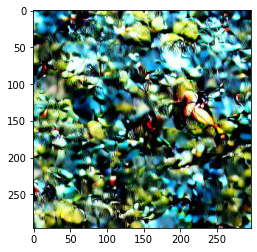

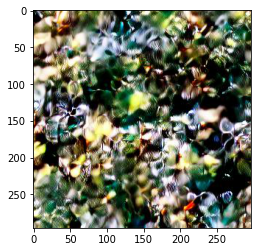

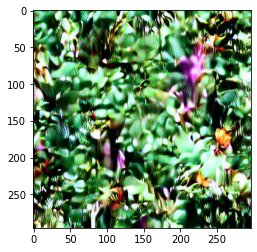

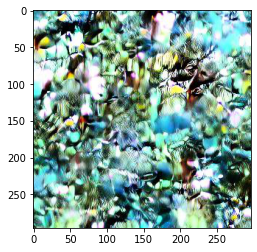

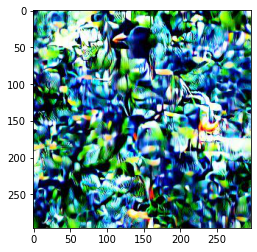

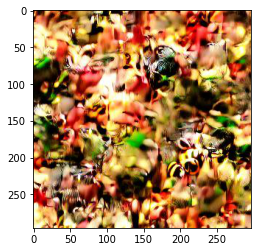

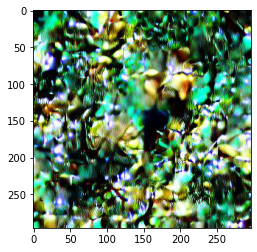

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

for image in images:
  im = Image.open(image) 
  plt.imshow(im)
  plt.show()